# 学修番号・氏名

- 学修番号: 22745102
- 氏名: 岩間和也

# 課題 1　日本語テキストのクラスタリング、分類

各自が収集した日本語のRSS/RDFニュースフィードに対し、クラスタリングおよび分類を行い、その結果について考察しなさい。

- 1.1 クラスタリング
  - 考察対象としたクラスタリングに用いたクラスタ数を決定した理由を示すこと
- 1.2 分類
  - 3つの分類アルゴリズムで分類を行うこと
  - 3つの分類アルゴリズムのそれぞれについて、教師データに対する分類精度（あてはまり）とテストデータに対する分類精度の比較を行うこと
  - テストデータの分類精度の計測では、グリッドサーチを用いて決定した最適なパラメータを用いること

以下のセルは自由に追加して構わない。
また、以下に注意すること。
- コメントやMarkdown形式での説明を適宜入れ、プログラムや結果をわかりやすく説明すること
- 【特に重要】JupyterLabのタブの下のバー（メニュー）にある ⏩ (Restart the kernel, then re-run the whole notebook) をクリックし、先頭セルから順番に全てのセルを実行、セルの番号が [1] から順に付き、実行結果を得た状態で提出すること

## 準備：日本語テキストデータの読み込み、前処理

In [1]:
import numpy as np
import spacy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# matplotlib: 日本語フォントの設定
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 'Yu Gothic', 'Meirio', 
                               'Takao', 'IPAexGothic', 'IPAPGothic', 'Noto Sans CJK JP']

# 日本語モデル
nlp = spacy.load('ja_core_news_lg')



# 日本語フィードデータの読み込み、確認
feeds = pd.read_csv('data/output_jp.csv')
feeds.head()

,url,title,summary
0,https://www.nhk.or.jp/rss/news/cat0.xml,大阪 クリニック放火事件からまもなく1年 遺族が手記公開,大阪のビルでクリニックが放火され、巻き込まれた26人が亡くなった事件からまもなく1年となるの...
1,https://www.nhk.or.jp/rss/news/cat0.xml,ワールドカップ 日本 森保監督 今大会の成果と今後の課題は,サッカーのワールドカップカタール大会の決勝トーナメント1回戦で、クロアチアに敗れた日本代表の...
2,https://www.nhk.or.jp/rss/news/cat0.xml,ロシア空軍基地に“ウクライナ軍の無人機攻撃” 大きな打撃か,ロシア国内の複数の空軍基地で爆発があり、ロシア国防省はウクライナ軍の無人機による攻撃を受けた...
3,https://www.nhk.or.jp/rss/news/cat0.xml,サッカー日本代表 たどり着いたもう1つの“新しい景色”,11月20日に開幕したサッカーのワールドカップカタール大会。7回目の出場となった日本代表はこ...
4,https://www.nhk.or.jp/rss/news/cat0.xml,北朝鮮 日本海向け約100発砲撃 2日連続 “米韓両軍への警告”,韓国軍は、北朝鮮が6日、日本海に向けておよそ100発の砲撃を行ったと発表しました。5日もおよ...


In [2]:
# title と summary を結合
# str.cat() により複数列の文字列を結合
# - sep=' ': 間に挟む文字列
# - na_rep='': NaN は空文字列に変換（指定しないと結合結果が NaN になる）
feeds['text'] = feeds['title'].str.cat(feeds['summary'], sep='。', na_rep='')

# 不要になった列を削除した処理用の DataFrame
df = feeds.drop(['title', 'summary'], axis=1)

# 確認
df.head()

,url,text
0,https://www.nhk.or.jp/rss/news/cat0.xml,大阪 クリニック放火事件からまもなく1年 遺族が手記公開。大阪のビルでクリニックが放火され、...
1,https://www.nhk.or.jp/rss/news/cat0.xml,ワールドカップ 日本 森保監督 今大会の成果と今後の課題は。サッカーのワールドカップカタール...
2,https://www.nhk.or.jp/rss/news/cat0.xml,ロシア空軍基地に“ウクライナ軍の無人機攻撃” 大きな打撃か。ロシア国内の複数の空軍基地で爆発...
3,https://www.nhk.or.jp/rss/news/cat0.xml,サッカー日本代表 たどり着いたもう1つの“新しい景色”。11月20日に開幕したサッカーのワー...
4,https://www.nhk.or.jp/rss/news/cat0.xml,北朝鮮 日本海向け約100発砲撃 2日連続 “米韓両軍への警告”。韓国軍は、北朝鮮が6日、日...


### 日本語テキストに対する前処理

- 表記の正規化
- トークン化（形態素解析）
- ストップワードの除去
- 見出し語化

In [3]:
# 不要な単語を除去
# - ストップワード (is_stop)
# - いくつかの品詞
#     AUX: 助動詞
#     PUNCT: 句読点
#     SPACE: 空白文字
#     SYM: 記号
#     X: その他
# - うまく取り除けない単語や文字
stop_pos = ['AUX', 'PUNCT', 'SPACE', 'SYM', 'X']
stop_words = ['.']

def token_to_add(w):
    t = w.text    # 単語
    p = w.pos_    # 品詞
    l = w.lemma_  # 原型

    # ストップワードは None を返す
    if w.is_stop:
        return None
    if p in stop_pos:
        return None
    if l in stop_words:
        return None

    if len(l) == 0:
        return t
    return l

def preprocess(text):
    tokens = []
    
    for w in nlp(text):
        t = token_to_add(w)
        if t is not None:
            tokens.append(t)

    # トークンのリストを返す
    return tokens

### テキストのベクトル化

In [4]:
# BoW でベクトル化
vectorizer_bow = CountVectorizer(tokenizer=preprocess)
vector_bow = vectorizer_bow.fit_transform(df.text)

# TF-IDF でベクトル化
vectorizer_tfidf = TfidfVectorizer(tokenizer=preprocess)
vector_tfidf = vectorizer_tfidf.fit_transform(df.text)

## 課題 1.1 クラスタリング

### 1.1.1 プログラムと実行結果

### 非階層的クラスタリング

- BoWとTF-IDF の結果をクラスタリング

### クラスタ数の推定

- 非階層的クラスタ分析ではクラスタ数を決めてデータをグループに分割
 - エルボー法
 - シルエット分析

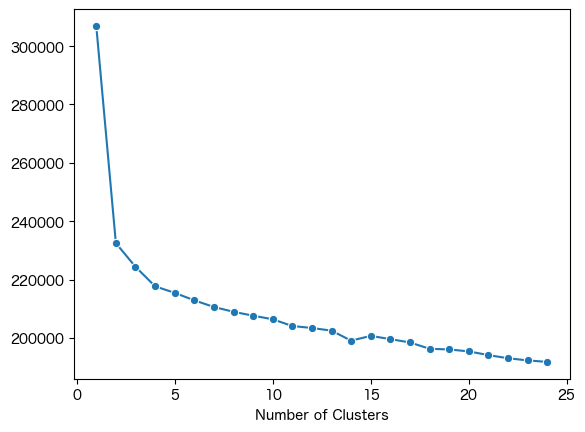

In [5]:
from sklearn.cluster import KMeans

# bowに対するエルボー法
# https://github.com/rasbt/python-machine-learning-book-2nd-edition/blob/master/code/ch11/ch11.py
x_range = range(1, 25)
distortions = []
for n in x_range:
    model = KMeans(n_clusters=n, random_state=0)
    model.fit(vector_bow)
    distortions.append(model.inertia_)

sns.lineplot(x=x_range, y=distortions, marker='o')
plt.xlabel('Number of Clusters')
plt.show()

エルボー法では2から4あたりが妥当そうに思われる

In [6]:
# bowに対するシルエット分析
# https://github.com/rasbt/python-machine-learning-book-2nd-edition/blob/master/code/ch11/ch11.py
from sklearn.metrics import silhouette_samples
from matplotlib import cm

def silhouette(X, n, plot=True):
    model = KMeans(n_clusters=n, random_state=0)
    model.fit(X)
    cluster_labels = set(model.labels_)
    n_clusters = len(cluster_labels)
    silhouette_vals = silhouette_samples(X, model.labels_, metric='euclidean')
    if plot:
        y_lower, y_upper = 0, 0
        yticks = []
        for i, c in enumerate(cluster_labels):
            c_silhouette_vals = silhouette_vals[model.labels_ == c]
            c_silhouette_vals.sort()
            y_upper += len(c_silhouette_vals)
            color = cm.jet(float(i) / n_clusters)
            plt.barh(range(y_lower, y_upper), c_silhouette_vals, height=1.0,
                     edgecolor='none', color=color)
            yticks.append((y_lower + y_upper) / 2.)
            y_lower += len(c_silhouette_vals)

    silhouette_avg = np.mean(silhouette_vals)
    if plot:
        plt.axvline(silhouette_avg, color="red", linestyle="--")
        plt.show()
    print('{} Clusters: Average silhouette coefficient: {:.3f}'.format(n, silhouette_avg))

for n in range(2, 25):
    silhouette(vector_bow, n, plot=False)

2 Clusters: Average silhouette coefficient: 0.769
3 Clusters: Average silhouette coefficient: 0.202
4 Clusters: Average silhouette coefficient: 0.176
5 Clusters: Average silhouette coefficient: 0.094
6 Clusters: Average silhouette coefficient: 0.052
7 Clusters: Average silhouette coefficient: 0.054
8 Clusters: Average silhouette coefficient: 0.052
9 Clusters: Average silhouette coefficient: 0.056
10 Clusters: Average silhouette coefficient: 0.050
11 Clusters: Average silhouette coefficient: 0.052
12 Clusters: Average silhouette coefficient: 0.060
13 Clusters: Average silhouette coefficient: 0.051
14 Clusters: Average silhouette coefficient: 0.055
15 Clusters: Average silhouette coefficient: 0.046
16 Clusters: Average silhouette coefficient: 0.047
17 Clusters: Average silhouette coefficient: 0.051
18 Clusters: Average silhouette coefficient: 0.058
19 Clusters: Average silhouette coefficient: 0.052
20 Clusters: Average silhouette coefficient: 0.059
21 Clusters: Average silhouette coeffic

シルエット係数が最大になっているのは2のとき

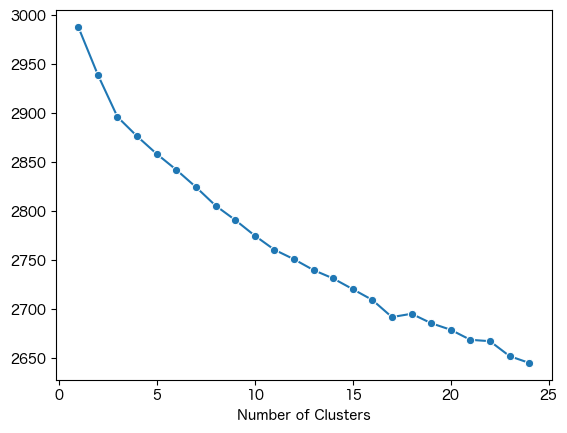

In [7]:
# tfidfに対するエルボー法
# https://github.com/rasbt/python-machine-learning-book-2nd-edition/blob/master/code/ch11/ch11.py
x_range = range(1, 25)
distortions = []
for n in x_range:
    model = KMeans(n_clusters=n, random_state=0)
    model.fit(vector_tfidf)
    distortions.append(model.inertia_)

sns.lineplot(x=x_range, y=distortions, marker='o')
plt.xlabel('Number of Clusters')
plt.show()

序盤と16周辺が候補値に思われる

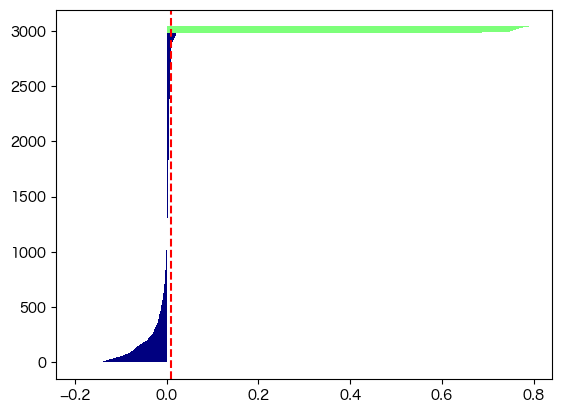

2 Clusters: Average silhouette coefficient: 0.009


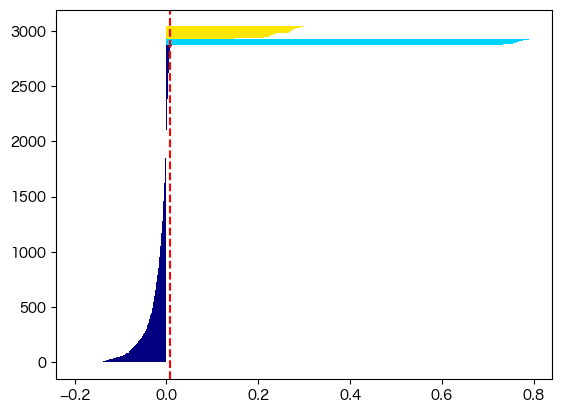

3 Clusters: Average silhouette coefficient: 0.008


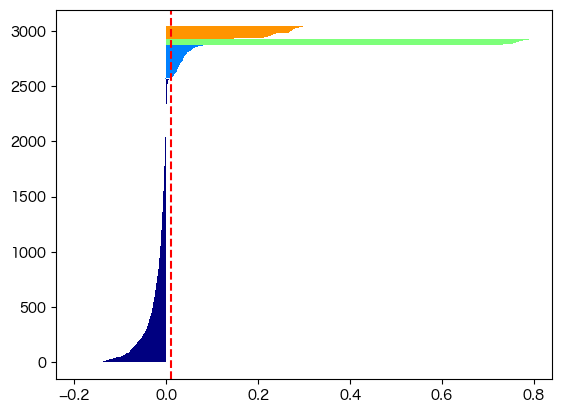

4 Clusters: Average silhouette coefficient: 0.011


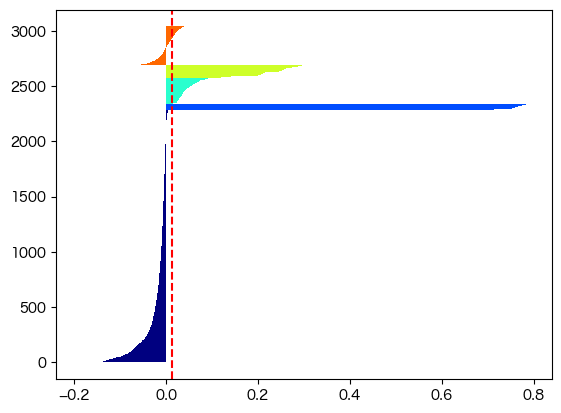

5 Clusters: Average silhouette coefficient: 0.013


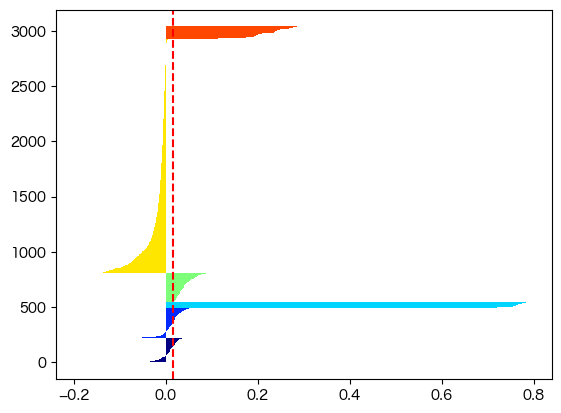

6 Clusters: Average silhouette coefficient: 0.015


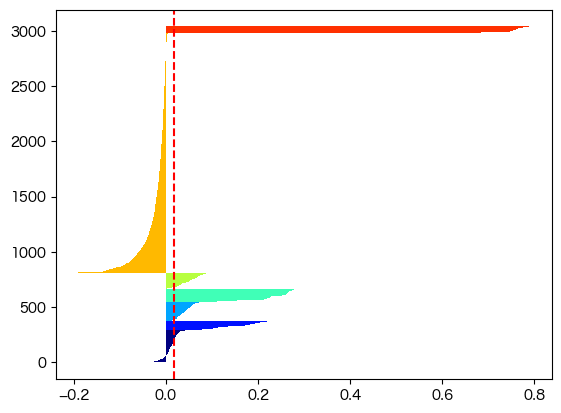

7 Clusters: Average silhouette coefficient: 0.018


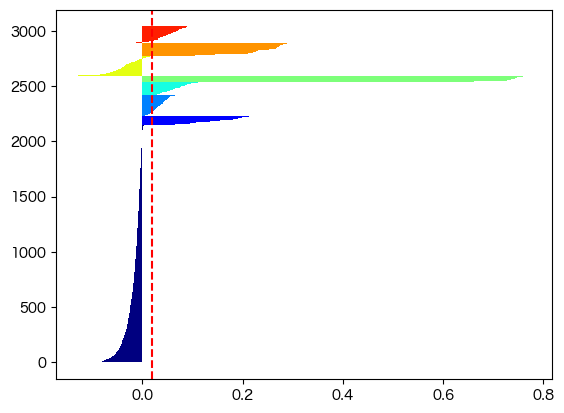

8 Clusters: Average silhouette coefficient: 0.020


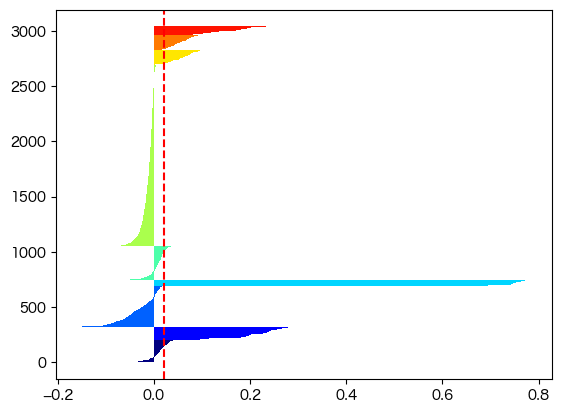

9 Clusters: Average silhouette coefficient: 0.022


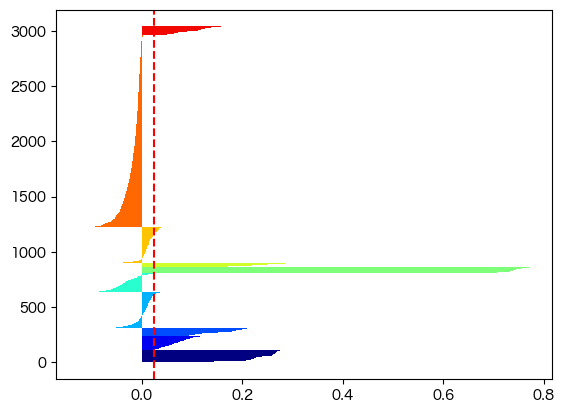

10 Clusters: Average silhouette coefficient: 0.025


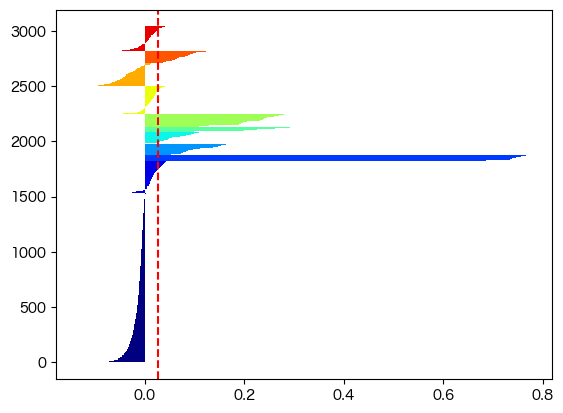

11 Clusters: Average silhouette coefficient: 0.027


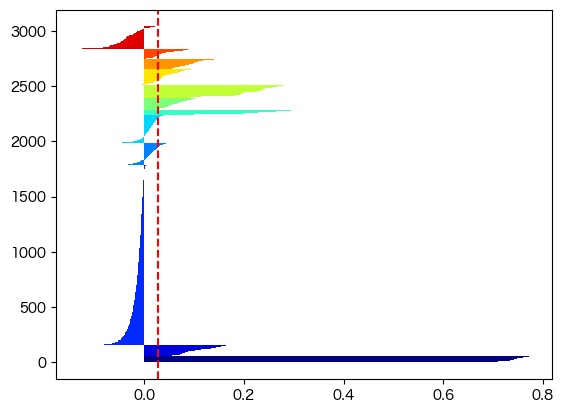

12 Clusters: Average silhouette coefficient: 0.028


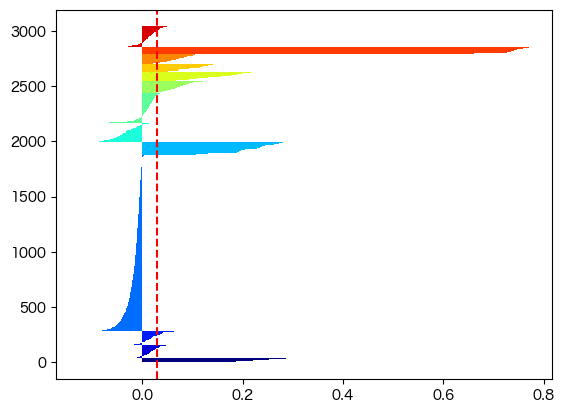

13 Clusters: Average silhouette coefficient: 0.029


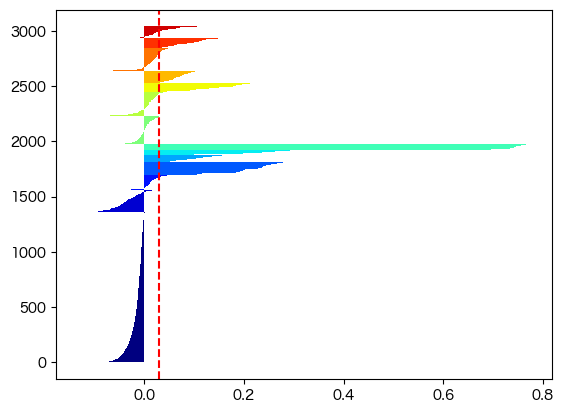

14 Clusters: Average silhouette coefficient: 0.030


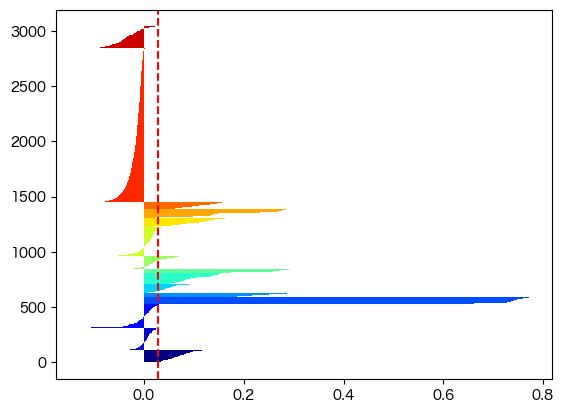

15 Clusters: Average silhouette coefficient: 0.027


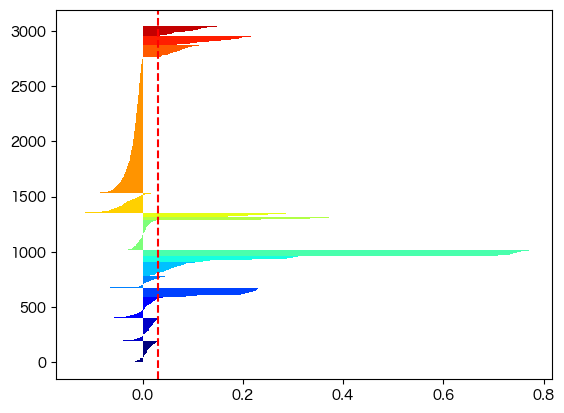

16 Clusters: Average silhouette coefficient: 0.031


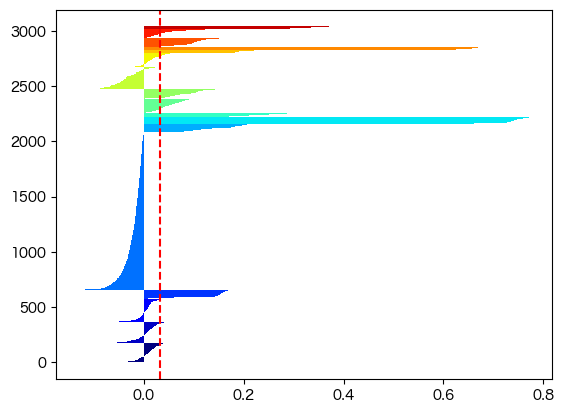

17 Clusters: Average silhouette coefficient: 0.031


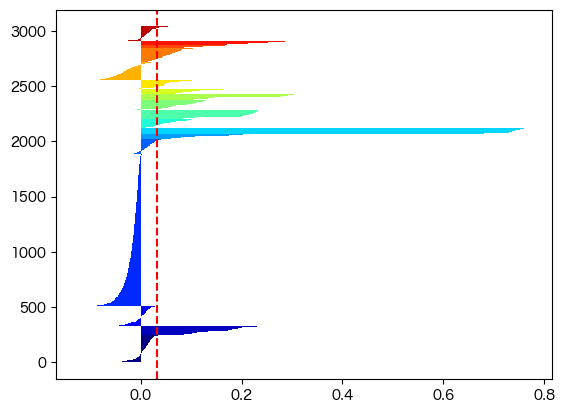

18 Clusters: Average silhouette coefficient: 0.033


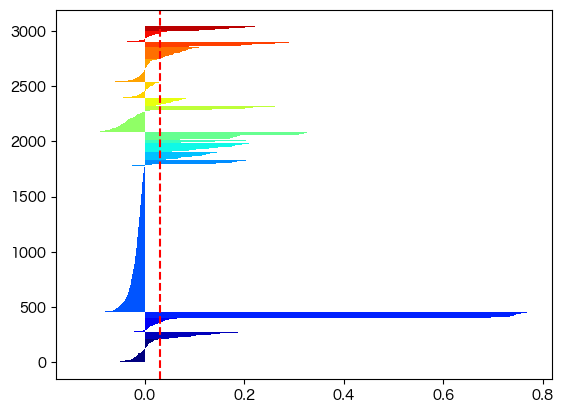

19 Clusters: Average silhouette coefficient: 0.032


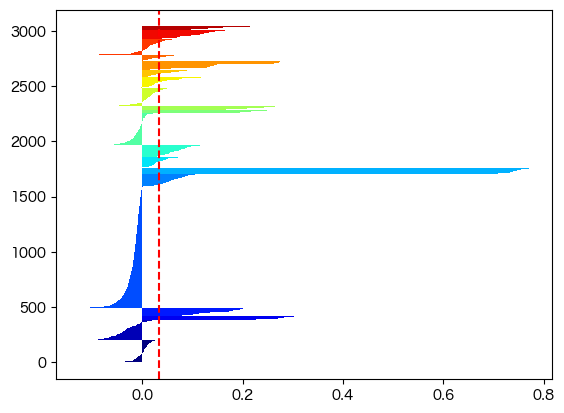

20 Clusters: Average silhouette coefficient: 0.034


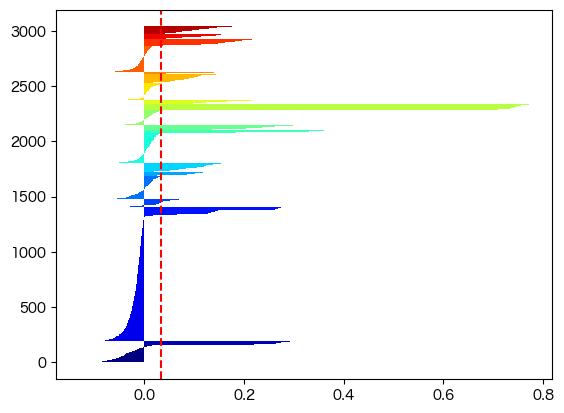

21 Clusters: Average silhouette coefficient: 0.033


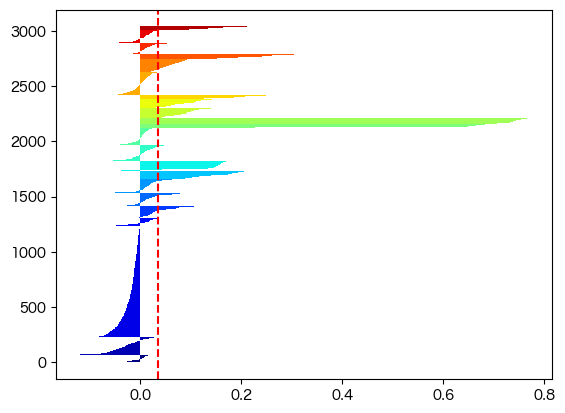

22 Clusters: Average silhouette coefficient: 0.035


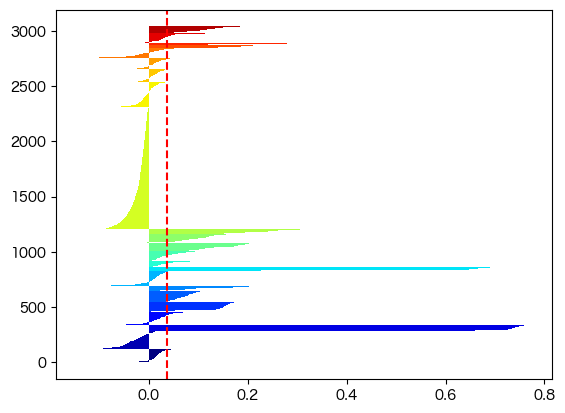

23 Clusters: Average silhouette coefficient: 0.037


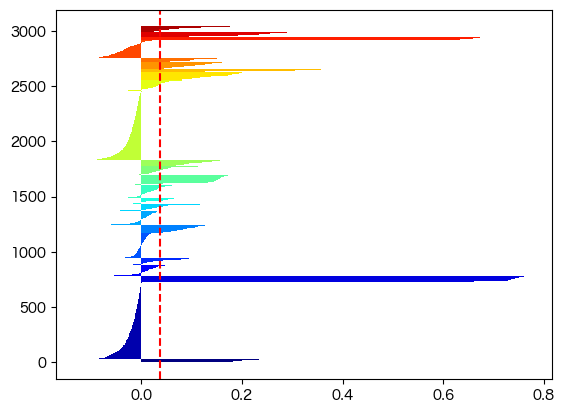

24 Clusters: Average silhouette coefficient: 0.037


In [8]:
# tfidfに対するシルエット分析

for n in range(2, 25):
    silhouette(vector_tfidf, n, plot=True)

シルエット係数が最大なのは23,24だった

## クラスタ数についての結論

bowのベクトルの場合の最適クラスタ数は2

tfidfのベクトルの場合の最適クラスタ数は23

この結果から、今回はクラスタ数を23として採用する

## クラスタ数が23の場合(tfidf)

In [9]:
# クラスタ数
N_clusters = 23

# KMeans の初期化
clusters = KMeans(n_clusters=N_clusters).fit_predict(vector_tfidf)

# 結果を DataFrame にまとめる
df_cluster = pd.DataFrame(clusters, columns=['cluster'])

# 確認しやすいようにテキストを追加
df_cluster['text'] = df.text

# 確認
df_cluster

,cluster,text
0,22,大阪 クリニック放火事件からまもなく1年 遺族が手記公開。大阪のビルでクリニックが放火され、...
1,3,ワールドカップ 日本 森保監督 今大会の成果と今後の課題は。サッカーのワールドカップカタール...
2,6,ロシア空軍基地に“ウクライナ軍の無人機攻撃” 大きな打撃か。ロシア国内の複数の空軍基地で爆発...
3,3,サッカー日本代表 たどり着いたもう1つの“新しい景色”。11月20日に開幕したサッカーのワー...
4,3,北朝鮮 日本海向け約100発砲撃 2日連続 “米韓両軍への警告”。韓国軍は、北朝鮮が6日、日...
...,...,...
3034,3,京都 八坂神社 平安時代の装束で「かるた始め」3年ぶり開催。京都・祇園の八坂神社で平安時代の...
3035,3,七福神を集め宝船に 「隅田川七福神めぐり」に多くの参拝客。新年を迎え、各地で七福神めぐりが行...
3036,3,香川 江戸時代から伝わる「水任流」 初泳ぎ披露する催し。江戸時代から伝わる古式泳法「水任流」...
3037,3,滋賀 弓道の上達願い ことし最初の矢を放つ「初射会」。弓道の愛好家たちが技術の上達を願ってこ...


In [10]:
# クラスタ 0 のテキスト
df_cluster.query('cluster==0')

,cluster,text
42,0,10月の実質賃金 前年同月を2.6％下回り7か月連続のマイナスに。物価の変動分を反映した働く...
355,0,株価 小幅に値上がり。6日の東京株式市場、株価は小幅に値上がりしました。
358,0,10月の家計調査 消費支出は前年同月比1.2％増 5か月連続の増加。ことし10月の家計調査で...
366,0,株価 小幅な値動き 狭い範囲で売り買い交錯。週明けの5日の東京株式市場、日経平均株価は、狭い...
377,0,米 11月の雇用統計 市場予想上回る FRBの政策判断などに関心。アメリカの11月の雇用統計...
...,...,...
2881,0,NY株式市場 ダウ平均株価は4年ぶりに前年下回る 下落率は8.7％。30日、ニューヨーク株式...
2891,0,中国 12月の製造業景況感指数 3か月連続 節目「50」を下回る。中国の12月の製造業の景況...
2897,0,NY株式市場 ダウ平均株価は4年ぶりに前年下回る 下落率は8.7％。30日、ニューヨーク株式...
2978,0,【詳しく】ことしの日本経済 注目は賃上げ 専門家はどうみる？。ことしの日本経済は、新型コロナ...


### クラスタごとの棒グラフ


In [11]:
# 単語の DataFrame (BoW)
df_words_bow = pd.DataFrame(vectorizer_bow.get_feature_names_out())

# テキストを BoW ベクトル化した結果を DataFrame
df_vector_bow = pd.DataFrame.sparse.from_spmatrix(vector_bow)

# 単語の DataFrame (TF-IDF)
df_words_tfidf = pd.DataFrame(vectorizer_tfidf.get_feature_names_out())

# テキストをベクトル化した結果の DataFrame
df_vector_tfidf = pd.DataFrame.sparse.from_spmatrix(vector_tfidf)



Cluster 0


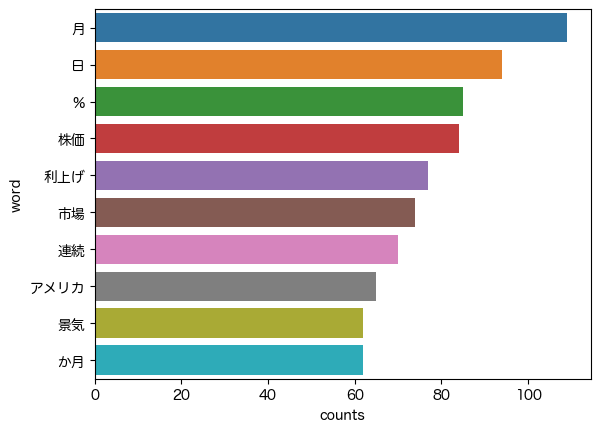

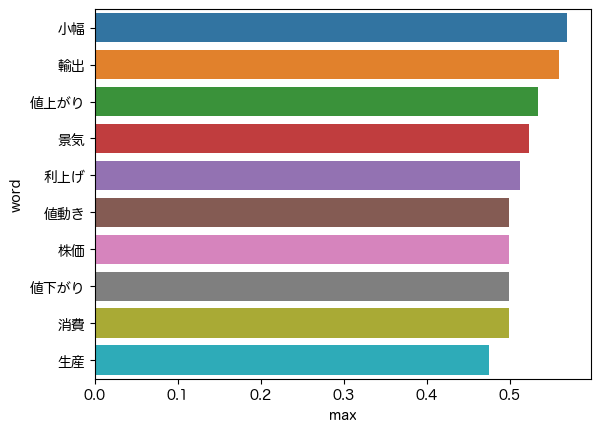

Cluster 1


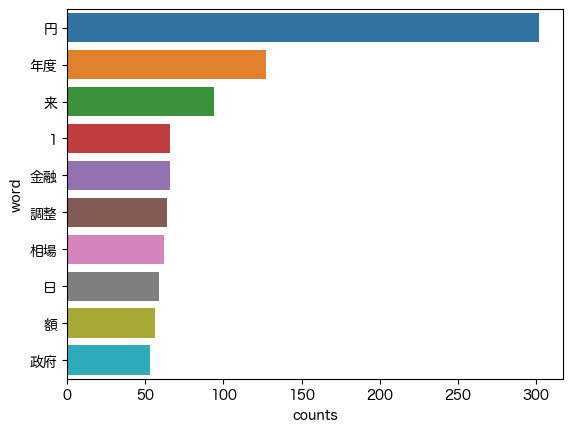

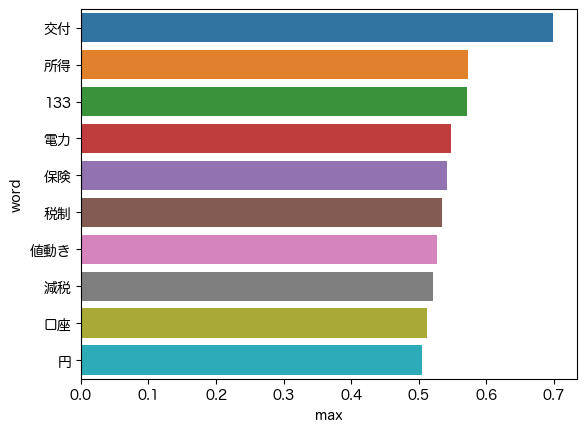

Cluster 2


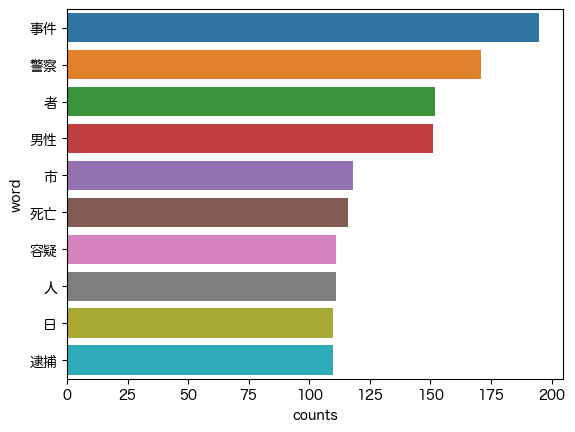

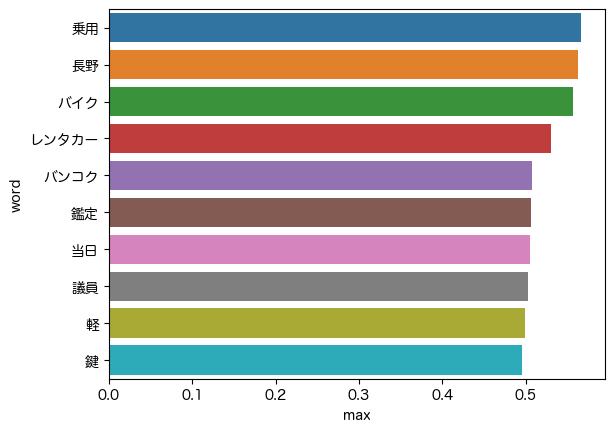

Cluster 3


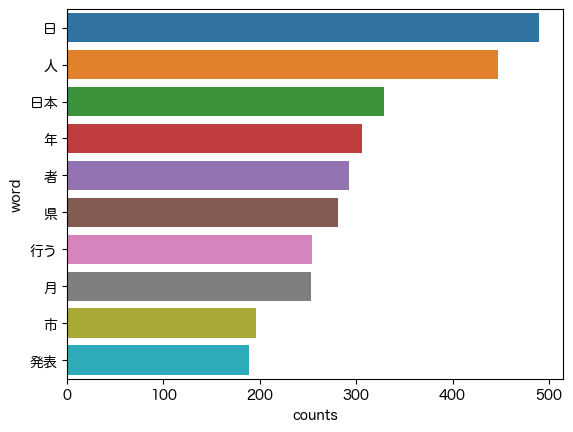

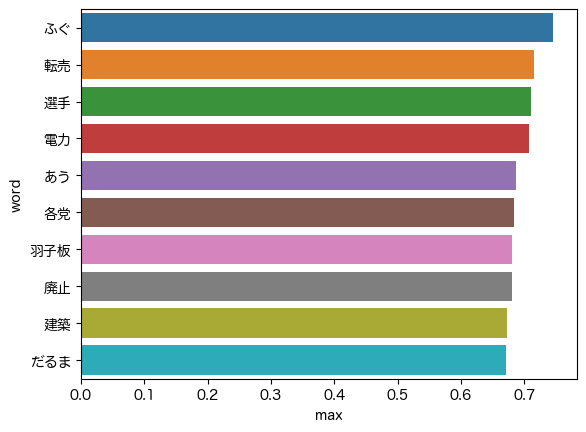

Cluster 4


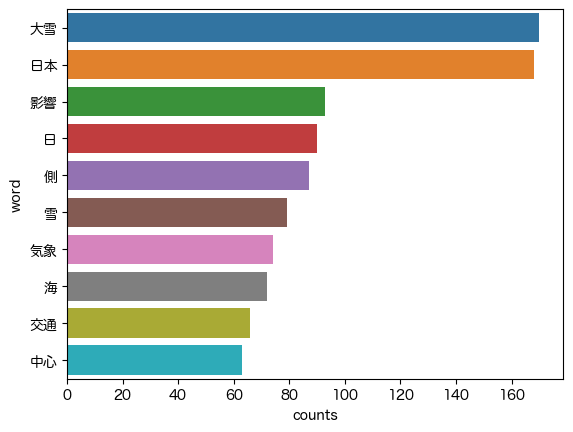

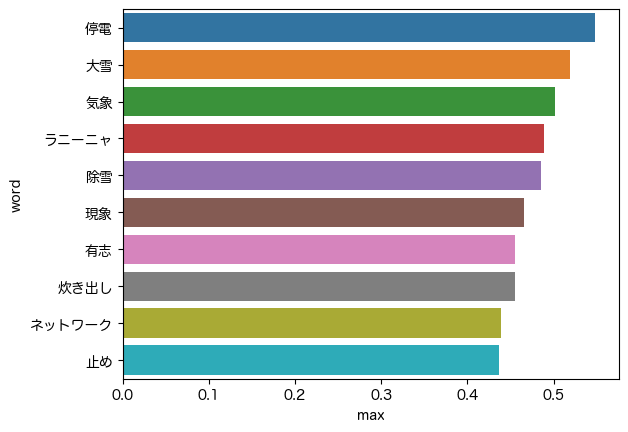

Cluster 5


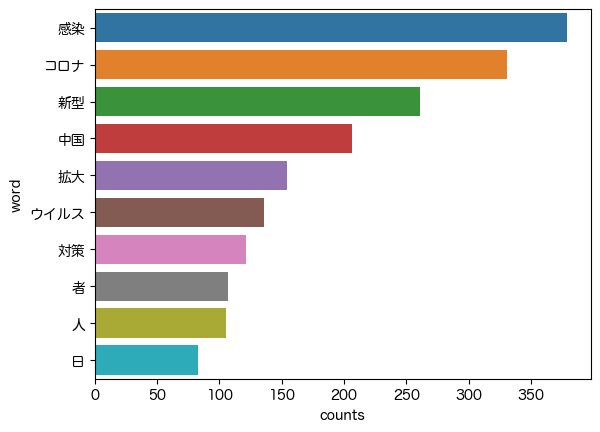

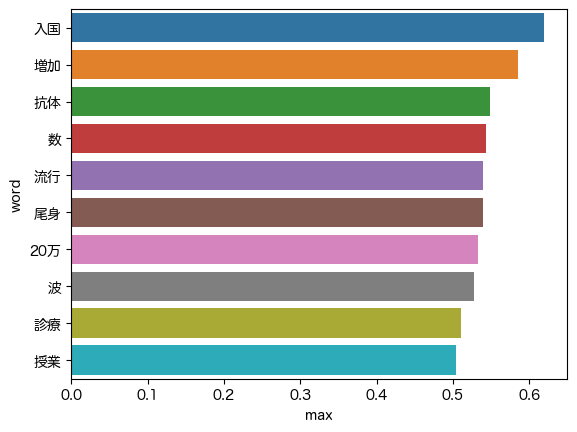

Cluster 6


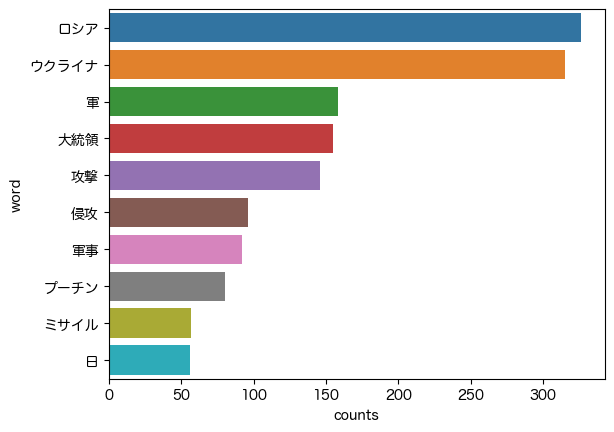

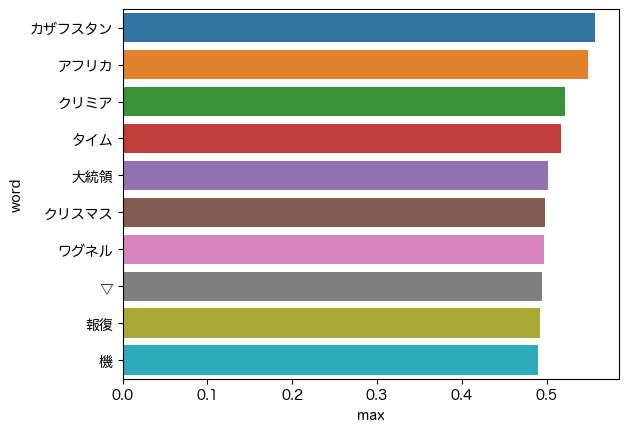

Cluster 7


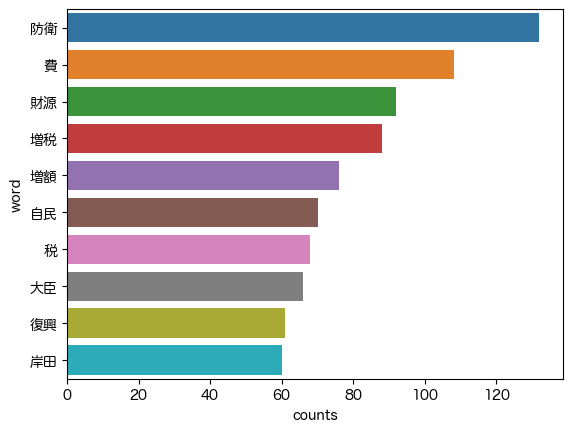

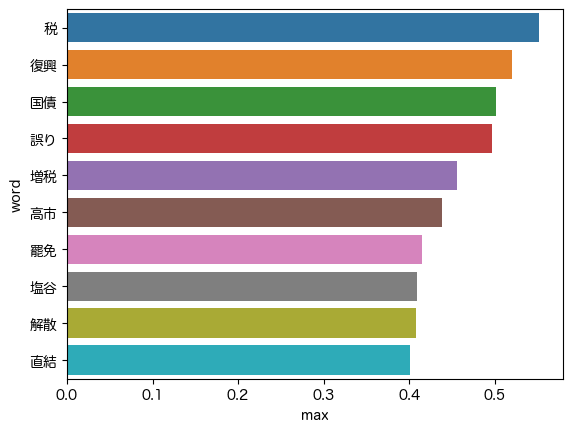

Cluster 8


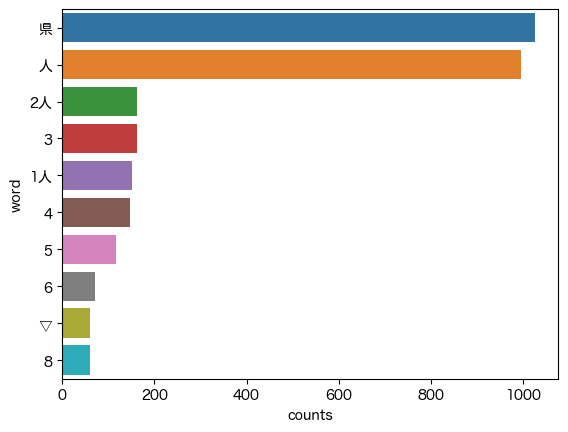

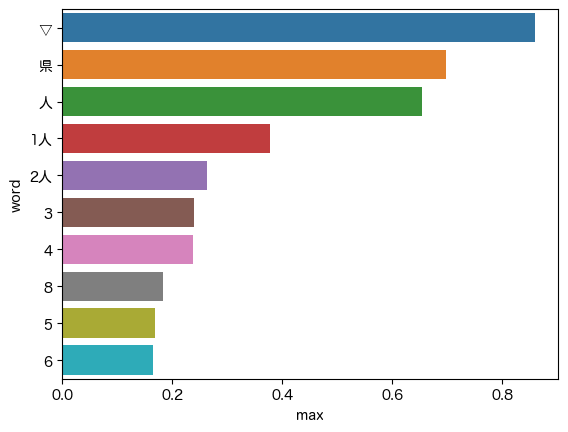

Cluster 9


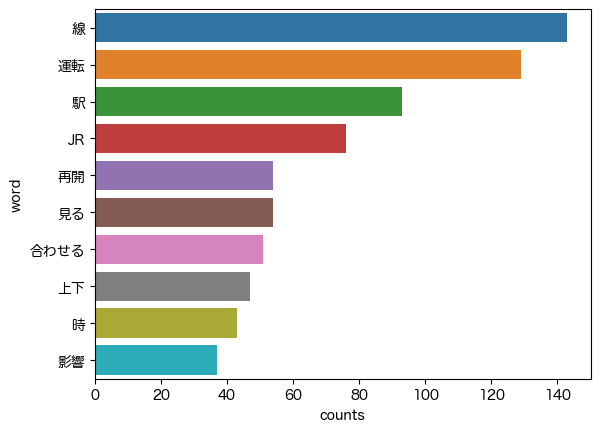

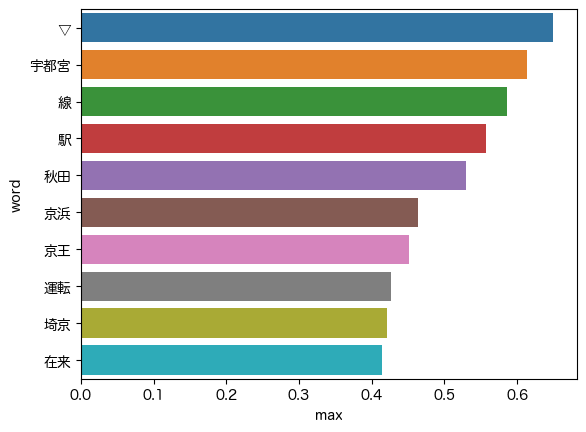

Cluster 10


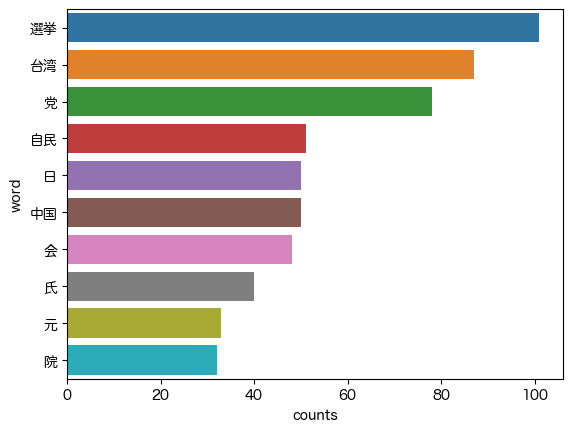

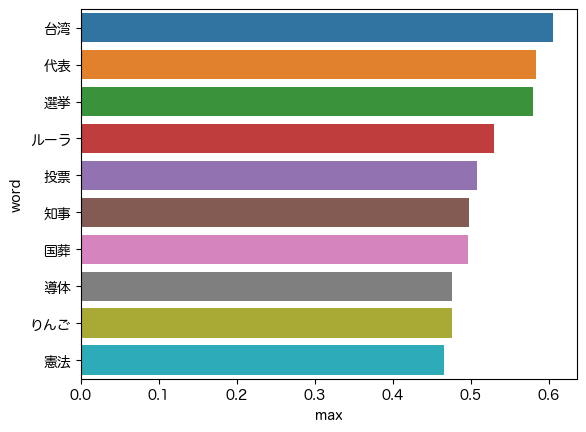

Cluster 11


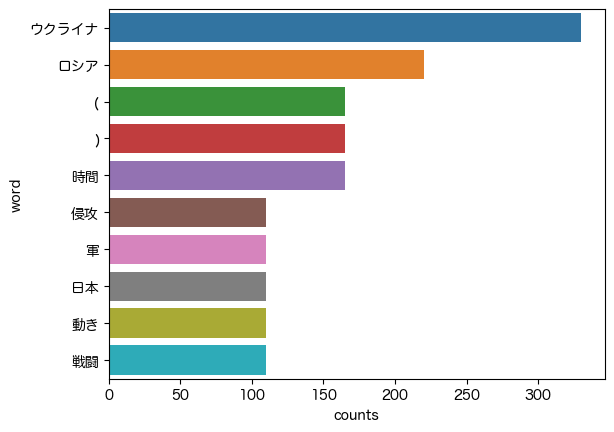

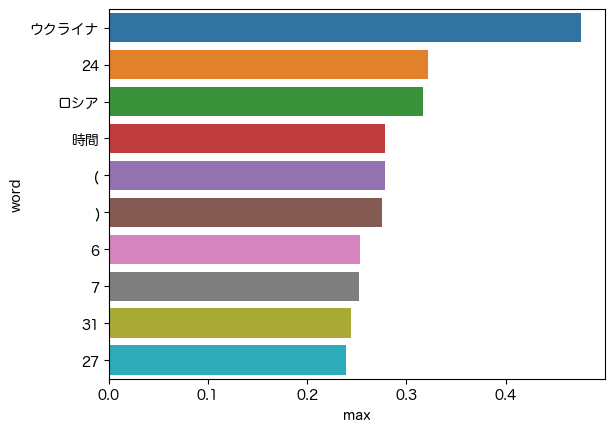

Cluster 12


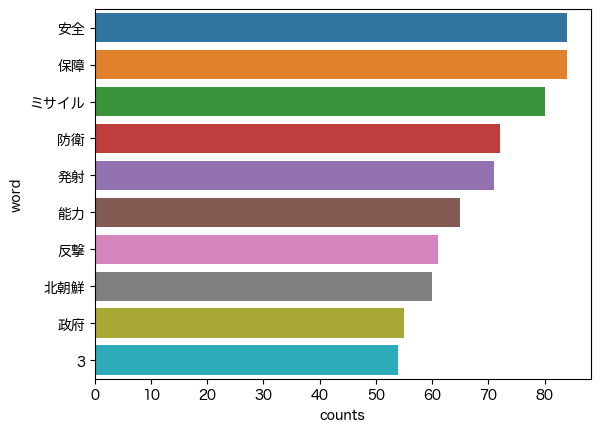

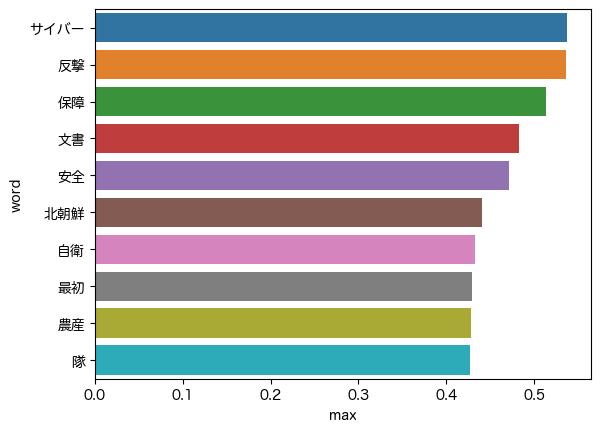

Cluster 13


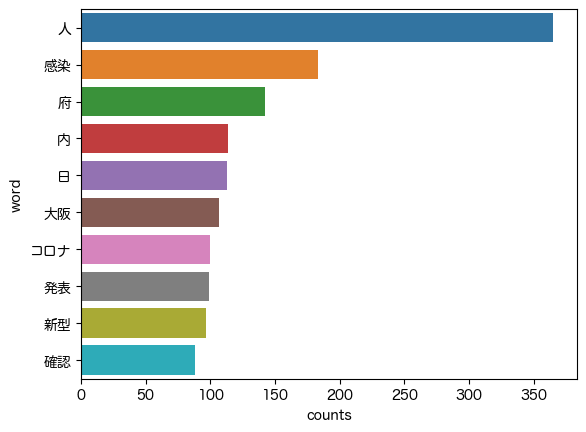

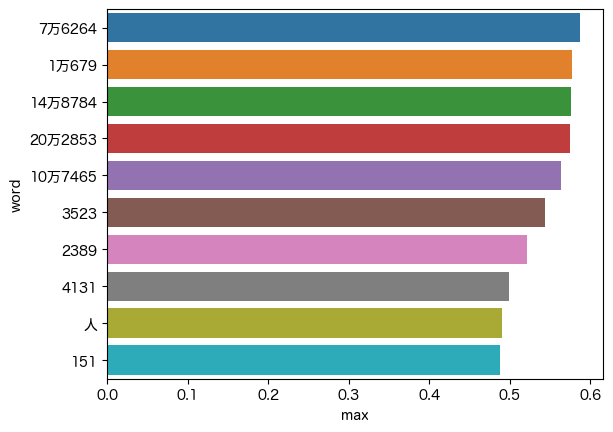

Cluster 14


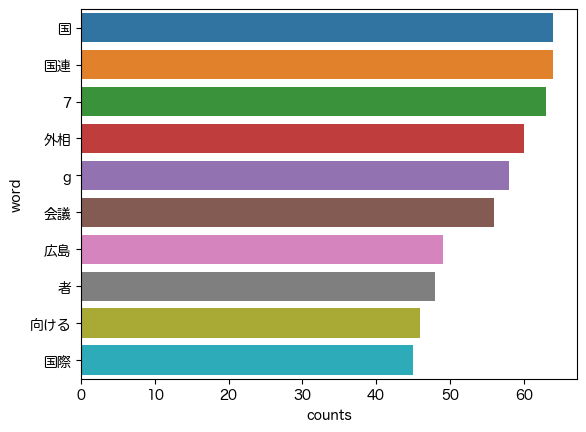

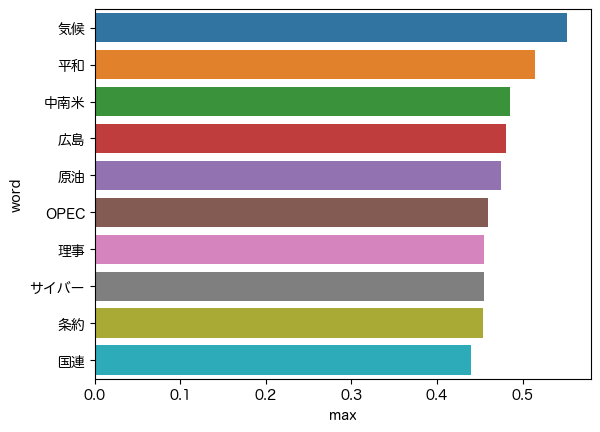

Cluster 15


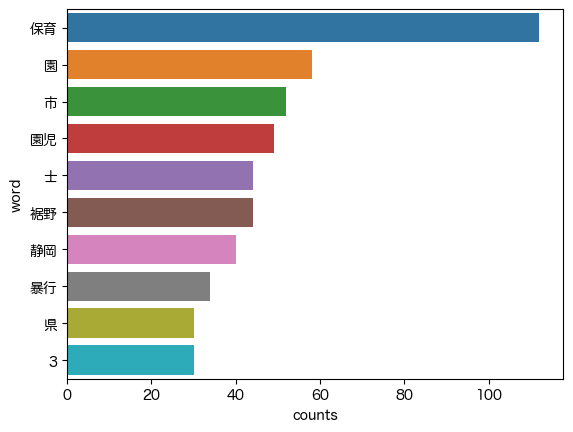

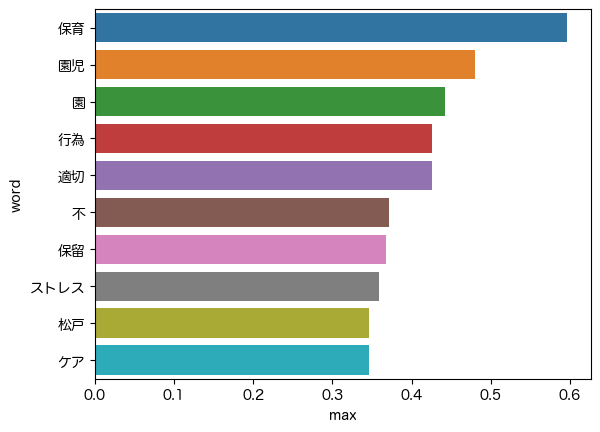

Cluster 16


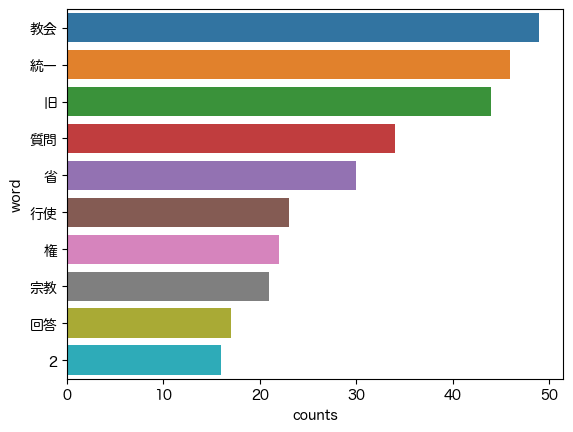

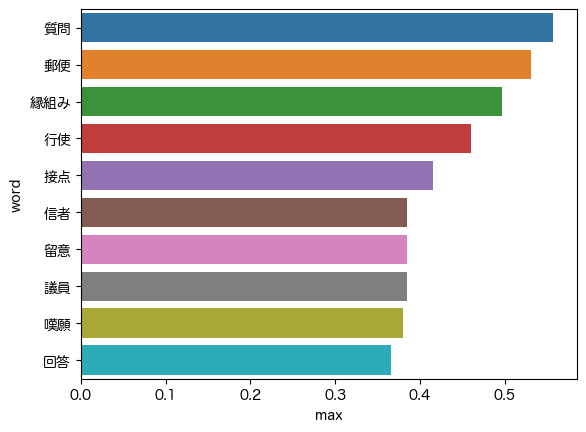

Cluster 17


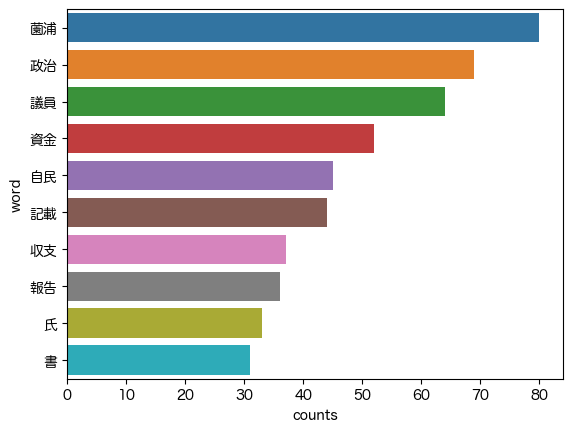

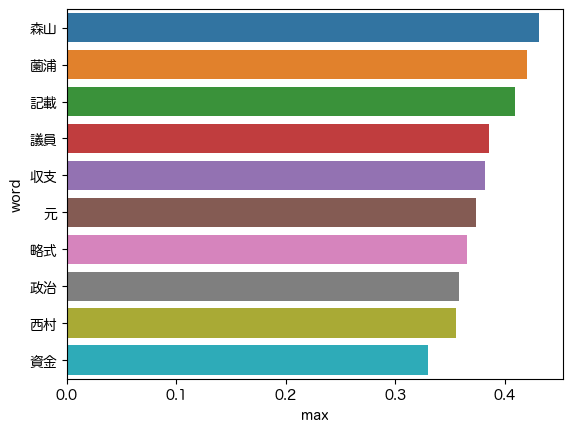

Cluster 18


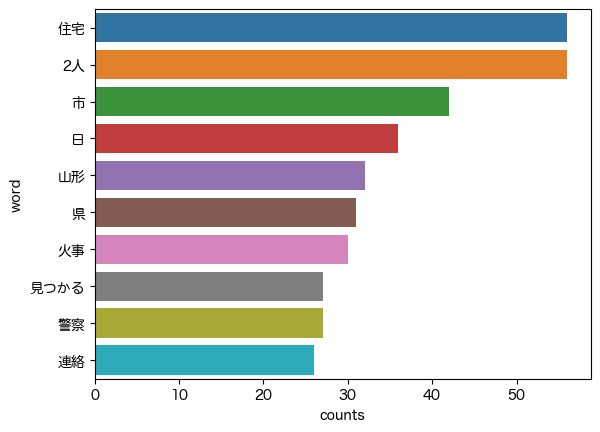

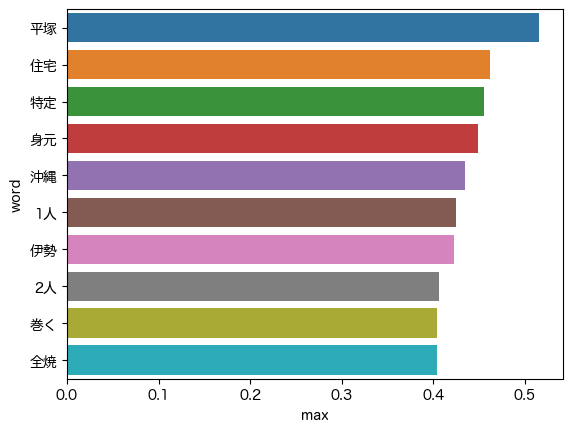

Cluster 19


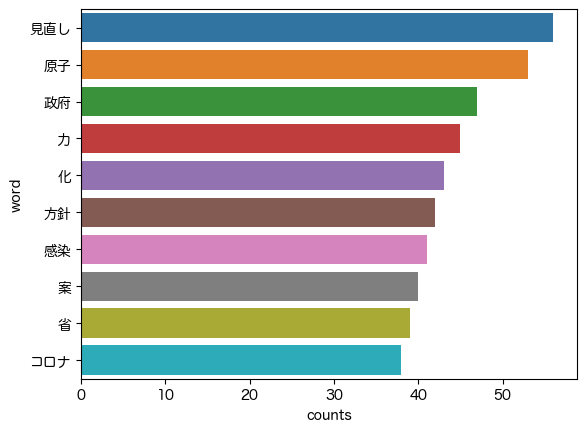

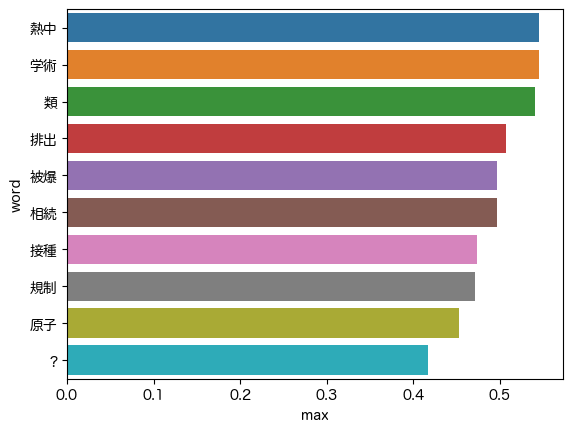

Cluster 20


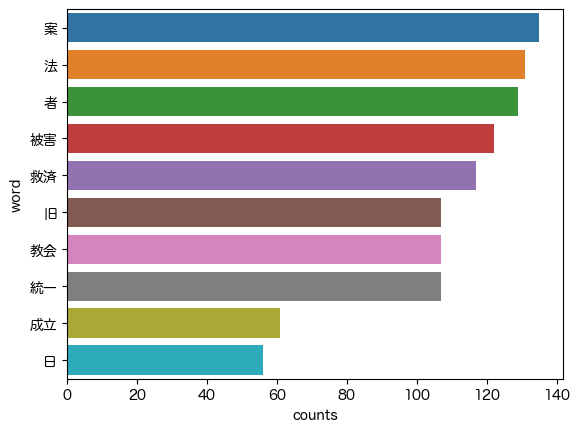

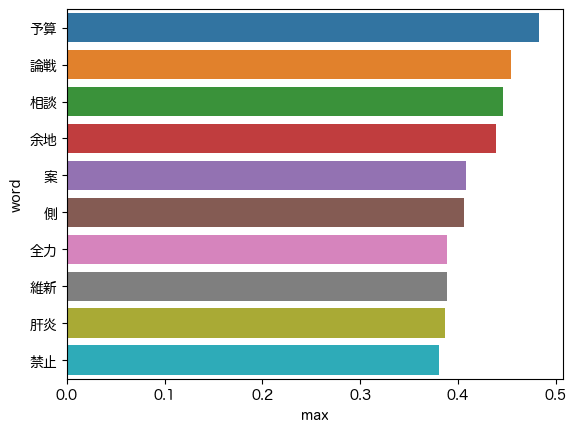

Cluster 21


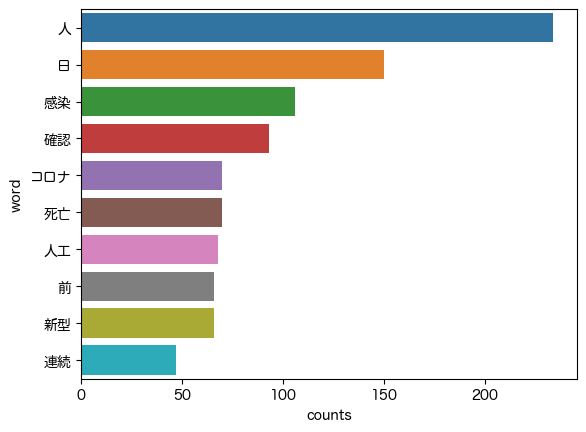

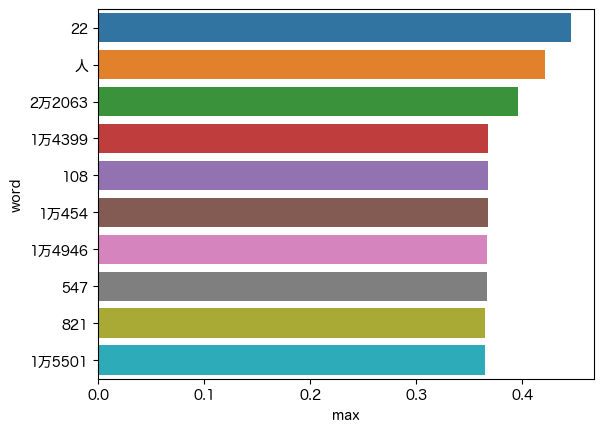

Cluster 22


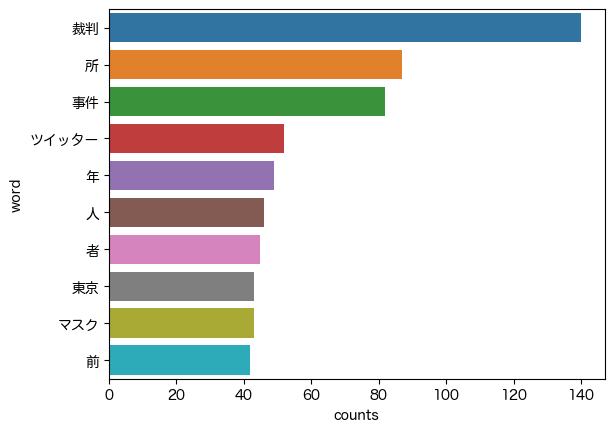

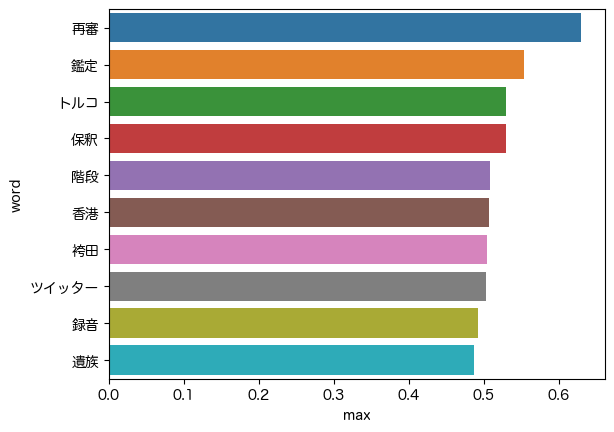

In [12]:
for i in range(0, N_clusters):
    print('Cluster', i)
    _cdf = df_cluster[df_cluster['cluster'] == i]

    # 頻度の棒グラフ
    df_counts = pd.concat([df_words_bow, df_vector_bow.iloc[_cdf.index].sum()], axis=1)
    df_counts.columns=['word', 'counts']
    df_bar_bow = df_counts.sort_values('counts', ascending=False).head(10)
    sns.barplot(x=df_bar_bow.counts, y=df_bar_bow.word, orient='h')
    plt.show()
    
    # TF-IDFの棒グラフ
    _cdf_max = df_vector_tfidf.iloc[_cdf.index].max()
    df_max = pd.concat([df_words_tfidf, _cdf_max], axis=1)
    df_max.columns=['word', 'max']
    df_bar_tfidf = df_max.sort_values('max', ascending=False).head(10)
    sns.barplot(x=df_bar_tfidf['max'], y=df_bar_tfidf.word, orient='h')
    plt.show()

### 1.1.2 実行結果の考察

- 約200字

半分以上のクラスタの棒グラフの結果から、どのようなニュースであったかについての類推が可能である、という印象を受けた。頻度とTF-IDFのグラフの結果については似通ったものもあるが、やや異なる傾向を示している。特に顕著だったのは新型コロナウイルスのニュースを扱ったクラスタで、頻度の棒グラフでは「感染」「確認」などの単語が上位に示され、数字が登場しないのに対して、TF-IDFではほぼ数値が上位を占めた。この新型コロナのクラスタは片方の棒グラフだけではニュースの要旨が伝わらないため、データを複数示すことの意義があったと考える。

## 課題 1.2 分類

### 1.2.1 プログラムと実行結果

### 分類モデルの作成（学習）


### 教師データの作成

URLに基づく教師ラベルをもとにカテゴリの予測を目指す

https://www.nhk.or.jp/rss/news/cat0.xml (主要ニュース)

https://www.nhk.or.jp/rss/news/cat1.xml (社会)

https://www.nhk.or.jp/rss/news/cat4.xml (政治)

https://www.nhk.or.jp/rss/news/cat5.xml (経済)

https://www.nhk.or.jp/rss/news/cat6.xml (国際)

https://www.nhk.or.jp/rss/news/cat3.xml (科学、医療)

In [13]:
# フィードのカテゴリごとの数を確認する

label_0 = ['cat0']
label_1 = ['cat1']
label_3 = ['cat3']
label_4 = ['cat4']
label_5 = ['cat5']
label_6 = ['cat6']

def get_label_test(url):
    url = url.lower()

    if any(map(lambda x: x in url, label_0)):
        return 0
    elif any(map(lambda x: x in url, label_1)):
        return 1
    elif any(map(lambda x: x in url, label_3)):
        return 3
    elif any(map(lambda x: x in url, label_4)):
        return 4
    elif any(map(lambda x: x in url, label_5)):
        return 5
    elif any(map(lambda x: x in url, label_6)):
        return 6

In [14]:
df['label'] = df['url'].map(lambda x: get_label_test(x))

# 数を確認
df['label'].value_counts()

1    1275
6     685
4     433
5     357
0     167
3     122
Name: label, dtype: int64

### 分類の方針

上記の数の割合から、社会カテゴリか、主要ニュース(0)を除いたそれ以外かの分類を行うこととする

In [15]:
label_0 = ['cat3', 'cat4', 'cat5', 'cat6']
label_1 = ['cat1']

# label_0 主要ニュースを除いた社会以外のカテゴリ：0
# label_1 社会カテゴリ：1
# それ以外(主要ニュース)：2
def get_label(url):
    url = url.lower()

    if any(map(lambda x: x in url, label_0)):
        return 0
    elif any(map(lambda x: x in url, label_1)):
        return 1
    else:
        return 2

In [16]:
df['label'] = df['url'].map(lambda x: get_label(x))

# label 0, 1 を取り出す
df = df.query('label != 2')

# 数を確認
df['label'].value_counts()

0    1597
1    1275
Name: label, dtype: int64

## ナイーブベイズ分類器

### 教師データの精度

正確度: 0.901, 適合度: 0.907, 再現率: 0.867, 特異度: 0.929


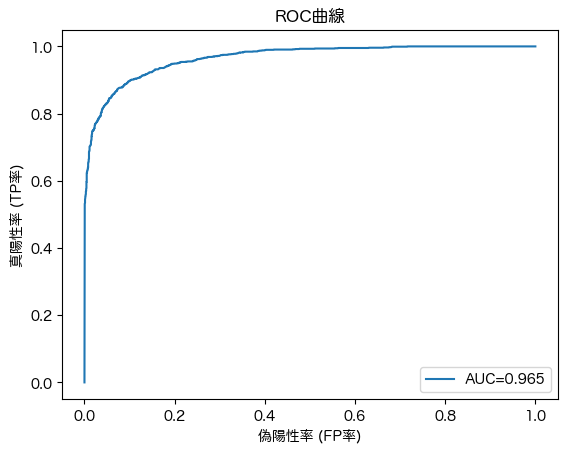

In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.naive_bayes import MultinomialNB

# 改めてテキストをベクトル化
# 初期化
vectorizer = CountVectorizer(tokenizer=preprocess)
# ベクトル化
vector = vectorizer.fit_transform(df.text)

# 説明変数、目的変数
# - vector が sparse のため toarray() により dense に変換
X = vector.toarray()
Y = df.label

# ナイーブベイズ分類器
# - 特徴量（説明変数）は整数のカウントデータ（単語の出現頻度など）
model = MultinomialNB()

# 学習
model.fit(X, Y)
# 教師データについてモデルからの予測値を計算
Y_predict = model.predict(X)

# 特異度の計算
matrix = confusion_matrix(Y, Y_predict)
specificity = matrix[0, 0] / (matrix[0, 1] + matrix[0, 0])
# 精度
print('正確度: {:.3f}, 適合度: {:.3f}, 再現率: {:.3f}, 特異度: {:.3f}'.format(
    accuracy_score(Y, Y_predict), precision_score(Y, Y_predict),
    recall_score(Y, Y_predict), specificity))
# ROC, AUC
Y_proba = model.predict_proba(X)
fpr, tpr, thresholds = roc_curve(Y, Y_proba[:, 1])
plt.plot(fpr, tpr, label='AUC={:.3f}'.format(auc(fpr, tpr)))
plt.xlabel('偽陽性率 (FP率)')
plt.ylabel('真陽性率 (TP率)')
plt.title('ROC曲線')
plt.legend()
plt.show()

### GridSearchCV を用いたテストデータの精度

グリッドのパラメータは適切なパラメータが自分ではわからなかったため、今回は各モデルでそれぞれ参考となるパラメータを流用した。

In [18]:
%%time

from sklearn.model_selection import GridSearchCV

model = MultinomialNB()

# 説明変数、目的変数
X = vector.toarray()
Y = df.label

# 探索パラメータ、グリッドの設定
# grid_paramの参考
# https://www.kaggle.com/code/prabanch/tweet-sentiment-extraction/notebook
param_range = list(range(1, 16, 1))
grid = [{'alpha': [.001]}]

# グリッドサーチの作成、実行
gs = GridSearchCV(model, param_grid=grid, scoring='roc_auc', cv=10, n_jobs=-1)
gs.fit(X, Y)

# 結果の表示
print('best AUC={:.3f}'.format(gs.best_score_))
print('parameter:', gs.best_params_)


best AUC=0.910
parameter: {'alpha': 0.001}
CPU times: user 534 ms, sys: 221 ms, total: 754 ms
Wall time: 2.41 s


In [19]:
score_df = pd.DataFrame(gs.cv_results_).sort_values('mean_test_score', ascending=False)
score_df[['mean_test_score', 'params']].head(5)

,mean_test_score,params
0,0.909542,{'alpha': 0.001}


## ランダムフォレスト


### 教師データの精度

正確度: 0.938, 適合度: 0.945, 再現率: 0.914, 特異度: 0.957


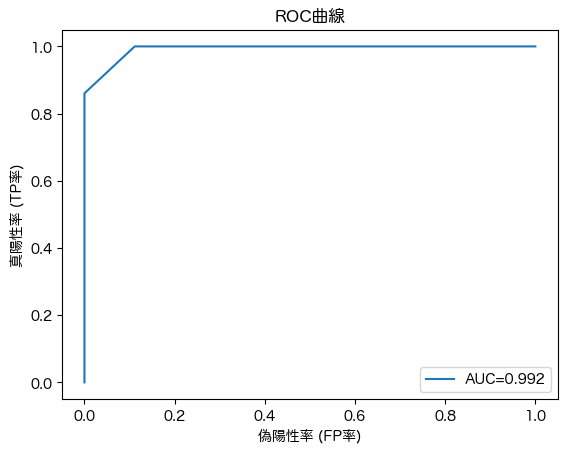

In [20]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()

# 学習
model.fit(X, Y)
# 教師データについてモデルからの予測値を計算
Y_predict = model.predict(X)

# 特異度の計算
matrix = confusion_matrix(Y, Y_predict)
specificity = matrix[0, 0] / (matrix[0, 1] + matrix[0, 0])
# 精度
print('正確度: {:.3f}, 適合度: {:.3f}, 再現率: {:.3f}, 特異度: {:.3f}'.format(
    accuracy_score(Y, Y_predict), precision_score(Y, Y_predict),
    recall_score(Y, Y_predict), specificity))
# ROC, AUC
Y_proba = model.predict_proba(X)
fpr, tpr, thresholds = roc_curve(Y, Y_proba[:, 1])
plt.plot(fpr, tpr, label='AUC={:.3f}'.format(auc(fpr, tpr)))
plt.xlabel('偽陽性率 (FP率)')
plt.ylabel('真陽性率 (TP率)')
plt.title('ROC曲線')
plt.legend()
plt.show()

### GridSearchCV を用いたテストデータの精度

グリッドのパラメータは適切なパラメータが自分ではわからなかったため、今回は各モデルでそれぞれ参考となるパラメータを流用した。

In [21]:
%%time

model = RandomForestClassifier()

# 説明変数、目的変数
X = vector.toarray()
Y = df.label

# 探索パラメータ、グリッドの設定
# grid_paramの参考
# https://teshi-learn.com/2020-02/python-ai-imple-2/
param_range = list(range(1, 16, 1))
grid = [{"n_estimators": [20,50,100],
            "criterion"   : ["gini", "entropy"],
            "max_depth"   : [None,3,5,7],
            "random_state": [0,10,20,30]
        }]

# グリッドサーチの作成、実行
gs = GridSearchCV(model, param_grid=grid, scoring='roc_auc', cv=10, n_jobs=-1)
gs.fit(X, Y)

# 結果の表示
print('best AUC={:.3f}'.format(gs.best_score_))
print('parameter:', gs.best_params_)

best AUC=0.912
parameter: {'criterion': 'entropy', 'max_depth': None, 'n_estimators': 100, 'random_state': 20}
CPU times: user 6.75 s, sys: 794 ms, total: 7.55 s
Wall time: 4min 58s


In [22]:
score_df = pd.DataFrame(gs.cv_results_).sort_values('mean_test_score', ascending=False)
score_df[['mean_test_score', 'params']].head(5)

,mean_test_score,params
58,0.911833,"{'criterion': 'entropy', 'max_depth': None, 'n..."
56,0.911536,"{'criterion': 'entropy', 'max_depth': None, 'n..."
57,0.910808,"{'criterion': 'entropy', 'max_depth': None, 'n..."
59,0.910677,"{'criterion': 'entropy', 'max_depth': None, 'n..."
8,0.910172,"{'criterion': 'gini', 'max_depth': None, 'n_es..."


## SVC

### 教師データの精度

正確度: 0.924, 適合度: 0.942, 再現率: 0.882, 特異度: 0.957


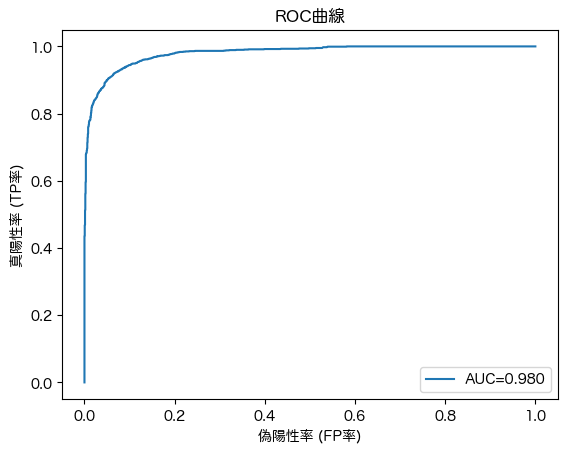

In [23]:
from sklearn.svm import SVC

model = SVC(probability=True)

# 学習
model.fit(X, Y)
# 教師データについてモデルからの予測値を計算
Y_predict = model.predict(X)

# 特異度の計算
matrix = confusion_matrix(Y, Y_predict)
specificity = matrix[0, 0] / (matrix[0, 1] + matrix[0, 0])
# 精度
print('正確度: {:.3f}, 適合度: {:.3f}, 再現率: {:.3f}, 特異度: {:.3f}'.format(
    accuracy_score(Y, Y_predict), precision_score(Y, Y_predict),
    recall_score(Y, Y_predict), specificity))
# ROC, AUC
Y_proba = model.predict_proba(X)
fpr, tpr, thresholds = roc_curve(Y, Y_proba[:, 1])
plt.plot(fpr, tpr, label='AUC={:.3f}'.format(auc(fpr, tpr)))
plt.xlabel('偽陽性率 (FP率)')
plt.ylabel('真陽性率 (TP率)')
plt.title('ROC曲線')
plt.legend()
plt.show()

### GridSearchCV を用いたテストデータの精度

グリッドのパラメータは適切なパラメータが自分ではわからなかったため、今回は各モデルでそれぞれ参考となるパラメータを流用した。

In [24]:
%%time

model = SVC()

# 説明変数、目的変数
X = vector.toarray()
Y = df.label

# 探索パラメータ、グリッドの設定
# grid_paramの参考
# 本来はこちらのパラメータを使用したかったが、実行時間の都合で断念した
# 本講義 Clf_5_grid_search.ipynb
# param_range = list(range(1, 16, 1))
# param_degree = list(range(3, 10, 3))

# - 実行時間短縮のためパラメータ簡略化
param_range = [0.01, 0.1, 1.0, 10.0]
param_degree = list(range(3, 10, 3))

grid = [{'kernel': ['linear'], 'C': param_range},
        {'kernel': ['rbf'], 'C': param_range, 'gamma': param_range},
        {'kernel': ['poly'], 'C': param_range, 'degree': param_degree}]

# グリッドサーチの作成、実行
gs = GridSearchCV(model, param_grid=grid, scoring='roc_auc', cv=3, n_jobs=-1)
gs.fit(X, Y)

# 結果の表示
print('best AUC={:.3f}'.format(gs.best_score_))
print('parameter:', gs.best_params_)

/Users/kazuya/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


best AUC=0.923
parameter: {'C': 0.01, 'kernel': 'linear'}
CPU times: user 19.2 s, sys: 457 ms, total: 19.7 s
Wall time: 10min 20s


In [25]:
score_df = pd.DataFrame(gs.cv_results_).sort_values('mean_test_score', ascending=False)
score_df[['mean_test_score', 'params']].head(5)

,mean_test_score,params
0,0.923481,"{'C': 0.01, 'kernel': 'linear'}"
12,0.922201,"{'C': 1.0, 'gamma': 0.01, 'kernel': 'rbf'}"
16,0.919424,"{'C': 10.0, 'gamma': 0.01, 'kernel': 'rbf'}"
1,0.911215,"{'C': 0.1, 'kernel': 'linear'}"
3,0.909780,"{'C': 10.0, 'kernel': 'linear'}"


### 1.2.2 実行結果の考察

- 約200字

AUCスコアについてはいずれの分類器でも0.9程度の高い精度を示すことができた。一方で、実行時間には大きく差が開いた。ナイーブベイズでは数秒程度でグリッドサーチが完了したのに対し、ランダムフォレストでは5分程度がかかった。また、SVCでは当初実行させようとしたパラメータでは2時間以上かけても計算が完了しなかったため、探索パラメータやデータ分割数を簡略化したが、それでも10分程度を要した。精度のスコアと実行時間からはナイーブベイズの優秀さが際立つ結果となったと考えられる。調べてみるとグリッドサーチのパラメータ調整による実行速度改善が多少は可能なようなので、今後の課題にできると考えている。

パラメータチューニングについての参考: 
https://www.haya-programming.com/entry/2018/06/18/221144